In [1]:
from typing import Tuple

import arviz as az
import daft
import jax
import jax.numpy as jnp
import matplotlib.image as matimg
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
from IPython.display import Latex as lt
from numpyro.contrib.funsor import config_enumerate, infer_discrete
from numpyro.infer import MCMC, NUTS, DiscreteHMCGibbs
from numpyro.infer.util import Predictive
from statsmodels.graphics.mosaicplot import mosaic

In [2]:
rng_key = jax.random.PRNGKey(2)
rng_key

DeviceArray([0, 2], dtype=uint32)

In [3]:
plt.rcParams["text.color"] = "white"
plt.rcParams["figure.dpi"] = 75
font = {"size": 18}
plt.rc("font", **font)

# Chapter 1
## A Murder Mystery

In [4]:
murderer = np.array([0.3, 0.7])

#### **1.1**

In [5]:
lt(r"$P\,( \texttt{murderer} = \texttt{Auburn}) = %s$" % (murderer[1]))

<IPython.core.display.Latex object>

#### **1.2**

In [6]:
lt(r"$P\,( \texttt{murderer} = \texttt{Grey}) = %s$" % (murderer[0]))

<IPython.core.display.Latex object>

#### **1.3**

In [7]:
lt(r"$P\,( \texttt{murderer} = \texttt{Grey}) + P\,( \texttt{murderer} = \texttt{Auburn})= %s$" % (murderer.sum()))

<IPython.core.display.Latex object>

#### **1.4**

In [8]:
lt(r"$\begin{array}{ll} P\,(\texttt{murderer} = \texttt{Grey}) = %s \\ P\,(\texttt{murderer} = \texttt{Auburn}) = %s \end{array}$" % (murderer[0], murderer[1]))

<IPython.core.display.Latex object>

#### **1.5**
$ \sum_{murderer} P\,(\texttt{murderer}) = 1 $

#### **Figure 1.1**

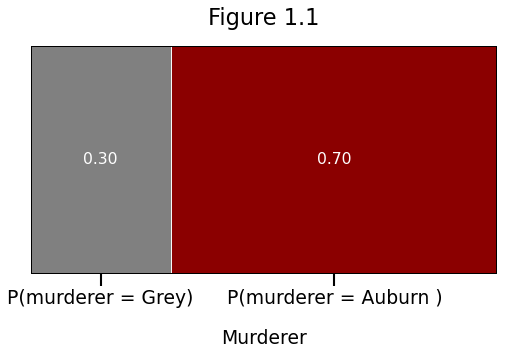

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))
data = {"P(murderer = Grey)": murderer[0], "P(murderer = Auburn )": murderer[1]}
props = lambda key: {"color": "darkred" if "P(murderer = Auburn )" in key else "gray"}
labelizer = lambda k: {
    ("P(murderer = Grey)",): f"{murderer[0]:.2f}",
    ("P(murderer = Auburn )",): f"{murderer[1]:.2f}",
}[k]
mosaic(data, labelizer=labelizer, properties=props, ax=ax)
ax.set_title("Figure 1.1", color="black", pad=20)
ax.xaxis.set_tick_params(width=2, length=12)
ax.set_xlabel("Murderer", labelpad=20)

plt.show()

## 1.1 Incorporating evidence

In [10]:
weapon_cpt = np.array([[0.9, 0.1], [0.2, 0.8]])

#### **1.6**

In [11]:
lt(r"$P\,( \texttt{weapon} = \texttt{revolver} | \texttt{murderer} = \texttt{Grey}) = %s$" % (weapon_cpt[0][0]))

<IPython.core.display.Latex object>

#### **1.7**

In [12]:
lt(r"$P\,( \texttt{weapon} = \texttt{dagger} | \texttt{murderer} = \texttt{Grey}) = %s$" % (weapon_cpt[0][1]))

<IPython.core.display.Latex object>

#### **Figure 1.2**

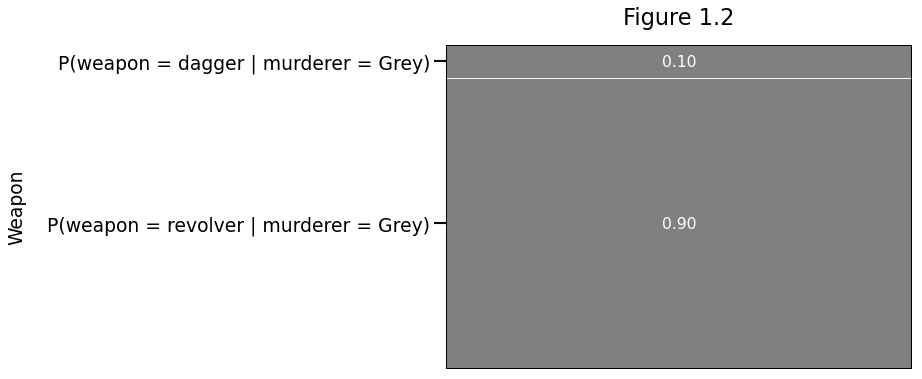

In [13]:
fig, ax = plt.subplots(figsize=(8, 4))
data = {
    "P(weapon = revolver | murderer = Grey)": weapon_cpt[0][0],
    "P(weapon = dagger | murderer = Grey)": weapon_cpt[0][1],
}
props = lambda key: {
    "color": "grey" if "P(weapon = revolver | murderer = Grey)" in key else "gray"
}
labelizer = lambda k: {
    ("P(weapon = revolver | murderer = Grey)",): f"{weapon_cpt[0][0]:.2f}",
    ("P(weapon = dagger | murderer = Grey)",): f"{weapon_cpt[0][1]:.2f}",
}[k]
mosaic(data, labelizer=labelizer, properties=props, ax=ax, horizontal=False)
ax.set_title("Figure 1.2", color="black", pad=20)
ax.yaxis.set_tick_params(width=2, length=12)
ax.set_ylabel("Weapon", labelpad=20)
fig.subplots_adjust(top=1.2)

plt.show()

#### **1.8**

In [14]:
lt(r"$P\,( \texttt{weapon} = \texttt{revolver} | \texttt{murderer} = \texttt{Auburn}) = %s$" % (weapon_cpt[1][0]))

<IPython.core.display.Latex object>

#### **1.9**

In [15]:
lt(r"$P\,( \texttt{weapon} = \texttt{dagger} | \texttt{murderer} = \texttt{Auburn}) = %s$" % (weapon_cpt[1][1]))

<IPython.core.display.Latex object>

#### **Figure 1.3**

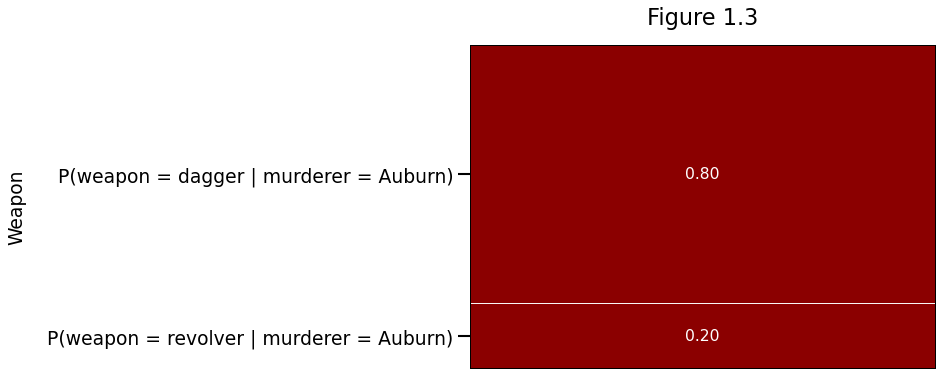

In [16]:
fig, ax = plt.subplots(figsize=(8, 4))
data = {
    "P(weapon = revolver | murderer = Auburn)": weapon_cpt[1][0],
    "P(weapon = dagger | murderer = Auburn)": weapon_cpt[1][1],
}
props = lambda key: {
    "color": "darkred"
    if "P(weapon = revolver | murderer = Auburn)" in key
    else "darkred"
}
labelizer = lambda k: {
    ("P(weapon = revolver | murderer = Auburn)",): f"{weapon_cpt[1][0]:.2f}",
    ("P(weapon = dagger | murderer = Auburn)",): f"{weapon_cpt[1][1]:.2f}",
}[k]
mosaic(data, labelizer=labelizer, properties=props, ax=ax, horizontal=False)
ax.set_title("Figure 1.3", color="black", pad=20)
ax.yaxis.set_tick_params(width=2, length=12)
ax.set_ylabel("Weapon", labelpad=20)
fig.subplots_adjust(top=1.2)

plt.show()

#### **1.10**

In [17]:
lt(r"$P\,(\,\text{weapon}=\text{revolver}\,|\, \text{murderer} \,) = \bigg\{\begin{array}{ll} %s \:\text{if murderer = Grey}\\%s \:\text{if murderer = Auburn} \end{array}$" % (weapon_cpt[0][0], weapon_cpt[1][0]))

<IPython.core.display.Latex object>

#### **Table 1.1**

In [18]:
pd.DataFrame(weapon_cpt, columns=["weapon=revolver", "weapon=dagger"], index=["murderer=Grey", "murderer=Auburn"])

,weapon=revolver,weapon=dagger
murderer=Grey,0.9,0.1
murderer=Auburn,0.2,0.8


#### **1.11**
$ \sum_{murderer} P\,(\texttt{weapon}|\texttt{murderer}) = 1 $

#### **1.12**
$ P\, (\texttt{raining}|\texttt{murderer}) = P\, (\texttt{raining})$

#### **1.13**
$ P\, (\texttt{murderer}|\texttt{raining}) = P\, (\texttt{murderer})$

## 1.2 A model of a murder

In [19]:
joint_table = np.array([[0.27, 0.03], [0.14, 0.56]])

In [20]:
def props_joint(tile: Tuple[str, str]):
    grey = {"color": "grey"}
    auburn = {"color": "darkred"}
    props = {
        ("P(Grey)", "P(dagger)"): grey,
        ("P(Grey)", "P(revolver)"): grey,
        ("P(Auburn)", "P(dagger)"): auburn,
        ("P(Auburn)", "P(revolver)"): auburn,
    }
    return props[tile]


def labelizer_joint(tile: Tuple[str, str]):
    labelizer = {
        ("P(Grey)", "P(dagger)"): f"{joint_table[0][1]:.2f}",
        ("P(Grey)", "P(revolver)"): f"{joint_table[0][0]:.2f}",
        ("P(Auburn)", "P(dagger)"): f"{joint_table[1][1]:.2f}",
        ("P(Auburn)", "P(revolver)"): f"{joint_table[1][0]:.2f}",
    }
    return labelizer[tile]

#### **Figure 1.4**

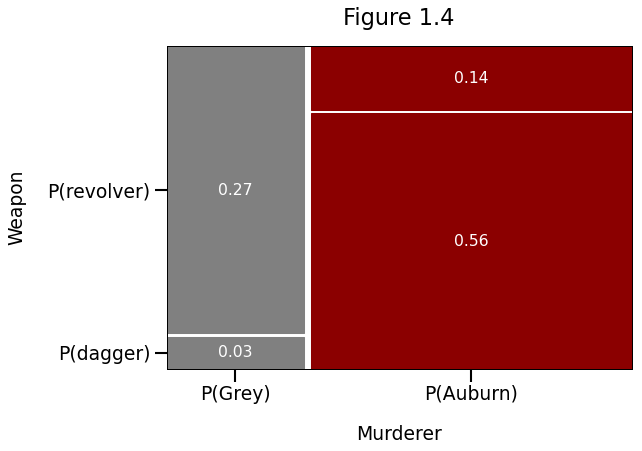

In [21]:
fig, ax = plt.subplots(figsize=(8, 4))
data = {
    ("P(Grey)", "P(dagger)"): joint_table[0][1],
    ("P(Grey)", "P(revolver)"): joint_table[0][0],
    ("P(Auburn)", "P(dagger)"): joint_table[1][1],
    ("P(Auburn)", "P(revolver)"): joint_table[1][0],
}
mosaic(
    data, gap=0.015, labelizer=labelizer_joint, properties=props_joint, ax=ax,
)
ax.set_title("Figure 1.4", color="black", pad=20)
ax.yaxis.set_tick_params(width=2, length=12)
ax.xaxis.set_tick_params(width=2, length=12)
ax.set_ylabel("Weapon", labelpad=20)
ax.set_xlabel("Murderer", labelpad=20)
fig.subplots_adjust(top=1.2)

plt.show()

#### **Figure 1.5**

Text(0.6, -0.2, 'P(weapon|murderer)')

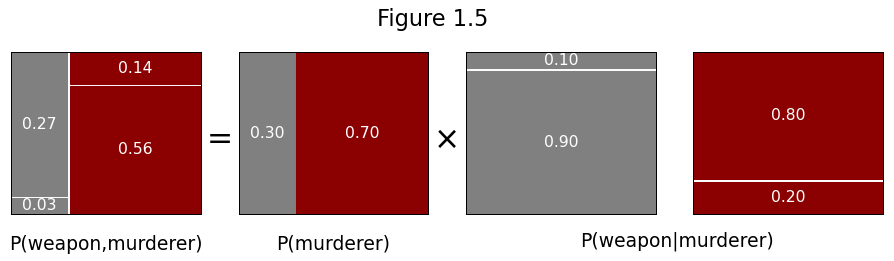

In [22]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 2))
fig.suptitle("Figure 1.5", color="black", y=1.5)

# Joint
joint = {
    ("P(Grey)", "P(dagger)"): joint_table[0][1],
    ("P(Grey)", "P(revolver)"): joint_table[0][0],
    ("P(Auburn)", "P(dagger)"): joint_table[1][1],
    ("P(Auburn)", "P(revolver)"): joint_table[1][0],
}
mosaic(
    joint, gap=0.015, labelizer=labelizer_joint, properties=props_joint, ax=ax1,
)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel("P(weapon,murderer)", labelpad=20)
fig.subplots_adjust(top=1.2)

# Murderer
murderer = {"P(murderer = Grey)": 0.3, "P(murderer = Auburn )": 0.7}
props = lambda key: {"color": "darkred" if "P(murderer = Auburn )" in key else "gray"}
labelizer = lambda k: {
    ("P(murderer = Grey)",): "0.30",
    ("P(murderer = Auburn )",): "0.70",
}[k]
mosaic(murderer, labelizer=labelizer, properties=props, ax=ax2)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel("P(murderer)", labelpad=20)

# ∑_weapon P(Weapon | Grey)
sum_weap_given_grey = {
    "P(weapon = revolver | murderer = Grey)": 0.9,
    "P(weapon = dagger | murderer = Grey)": 0.1,
}
props = lambda key: {
    "color": "grey" if "P(weapon = revolver | murderer = Grey)" in key else "gray"
}
labelizer = lambda k: {
    ("P(weapon = revolver | murderer = Grey)",): "0.90",
    ("P(weapon = dagger | murderer = Grey)",): "0.10",
}[k]
mosaic(
    sum_weap_given_grey,
    gap=0.02,
    labelizer=labelizer,
    properties=props,
    ax=ax3,
    horizontal=False,
)
ax3.set_xticks([])
ax3.set_yticks([])
# ax3.set_xlabel("P(weapon|murderer)", labelpad=20)

# ∑_weapon P(Weapon | Auburn)
sum_weap_given_auburn = {
    "P(weapon = revolver | murderer = Auburn)": 0.2,
    "P(weapon = dagger | murderer = Auburn)": 0.8,
}
props = lambda key: {
    "color": "darkred"
    if "P(weapon = revolver | murderer = Auburn)" in key
    else "darkred"
}
labelizer = lambda k: {
    ("P(weapon = revolver | murderer = Auburn)",): "0.20",
    ("P(weapon = dagger | murderer = Auburn)",): "0.80",
}[k]
mosaic(
    sum_weap_given_auburn,
    gap=0.02,
    labelizer=labelizer,
    properties=props,
    ax=ax4,
    horizontal=False,
)
ax4.set_xticks([])
ax4.set_yticks([])


ax1.text(1.03, 0.4, "=", fontsize=30, color="black")
ax2.text(1.03, 0.4, "×", fontsize=30, color="black")
ax3.text(0.6, -0.2, "P(weapon|murderer)", fontsize=18, color="black")


#### **1.14**
$ \sum_A \sum_B P\,(\texttt{A},\texttt{B}) = 1 $

#### **1.15**
$P\, (\texttt{weapon,murderer}) = P\, (\texttt{murderer}) P\, (\texttt{weapon}|\texttt{murderer}) $

#### **1.16**
$P\, (\texttt{A,B}) = P\, (\texttt{A}) P\, (\texttt{B}|\texttt{A}) $

#### **1.17**
$\sum_{weapon} P\,(\texttt{weapon},\texttt{murderer} = \texttt{Grey}) = P\, (\texttt{murderer} = \texttt{Grey})$

#### **1.18**
$\sum_{weapon} P\,(\texttt{weapon},\texttt{murderer}) = P\, (\texttt{murderer})$

#### **1.19**
$P\, (A) = \sum_B P\, (A,B)$

#### **1.20**
$P\, (A, C, D) = P\, (A) P\, (C,D|A)$

#### **1.21**
$P\, (A) = \sum_C \sum_D P\, (A,C,D)$

#### **Figure 1.6**

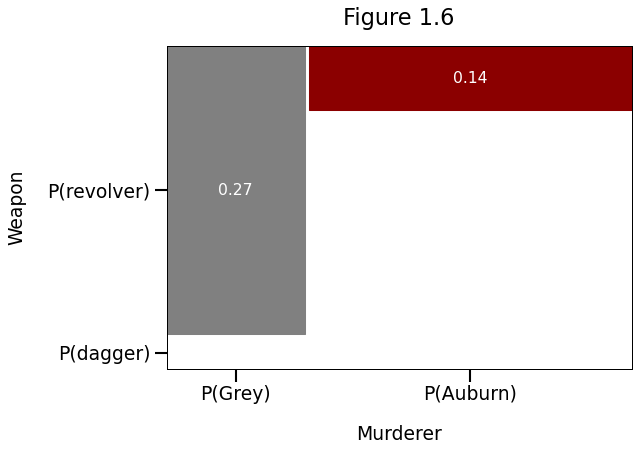

In [23]:
def props_joint(tile: Tuple[str, str]):
    grey = {"color": "grey"}
    auburn = {"color": "darkred"}
    white = {"color": "white"}
    props = {
        ("P(Grey)", "P(dagger)"): white,
        ("P(Grey)", "P(revolver)"): grey,
        ("P(Auburn)", "P(dagger)"): white,
        ("P(Auburn)", "P(revolver)"): auburn,
    }
    return props[tile]


fig, ax = plt.subplots(figsize=(8, 4))
data = {
    ("P(Grey)", "P(dagger)"): 0.03,
    ("P(Grey)", "P(revolver)"): 0.27,
    ("P(Auburn)", "P(dagger)"): 0.56,
    ("P(Auburn)", "P(revolver)"): 0.14,
}
mosaic(
    data, gap=0.01, labelizer=labelizer_joint, properties=props_joint, ax=ax,
)
ax.set_title("Figure 1.6", color="black", pad=20)
ax.yaxis.set_tick_params(width=2, length=12)
ax.xaxis.set_tick_params(width=2, length=12)
ax.set_ylabel("Weapon", labelpad=20)
ax.set_xlabel("Murderer", labelpad=20)
fig.subplots_adjust(top=1.2)

plt.show()

#### **Figure 1.7**

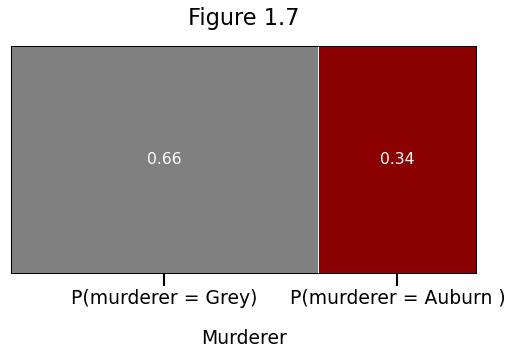

In [24]:
fig, ax = plt.subplots(figsize=(8, 4))
data = {"P(murderer = Grey)": 0.66, "P(murderer = Auburn )": 0.34}
props = lambda key: {"color": "darkred" if "P(murderer = Auburn )" in key else "gray"}
labelizer = lambda k: {
    ("P(murderer = Grey)",): "0.66",
    ("P(murderer = Auburn )",): "0.34",
}[k]
mosaic(data, labelizer=labelizer, properties=props, ax=ax)
ax.set_title("Figure 1.7", color="black", pad=20)
ax.xaxis.set_tick_params(width=2, length=12)
ax.set_xlabel("Murderer", labelpad=20)

plt.show()

## 1.3 Working with larger models

#### **Figure 1.8**

Text(0.6, -0.2, 'P(weapon|murderer)')

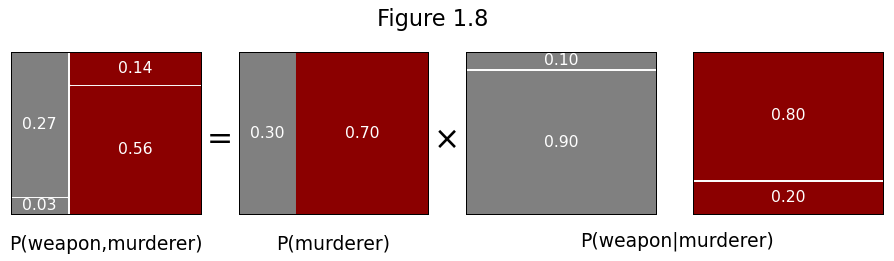

In [25]:
def props_joint(tile: Tuple[str, str]):
    grey = {"color": "grey"}
    auburn = {"color": "darkred"}
    props = {
        ("P(Grey)", "P(dagger)"): grey,
        ("P(Grey)", "P(revolver)"): grey,
        ("P(Auburn)", "P(dagger)"): auburn,
        ("P(Auburn)", "P(revolver)"): auburn,
    }
    return props[tile]


fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 2))
fig.suptitle("Figure 1.8", color="black", y=1.5)

# Joint
joint = {
    ("P(Grey)", "P(dagger)"): 0.03,
    ("P(Grey)", "P(revolver)"): 0.27,
    ("P(Auburn)", "P(dagger)"): 0.56,
    ("P(Auburn)", "P(revolver)"): 0.14,
}
mosaic(
    joint, gap=0.015, labelizer=labelizer_joint, properties=props_joint, ax=ax1,
)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel("P(weapon,murderer)", labelpad=20)
fig.subplots_adjust(top=1.2)

# Murderer
murderer = {"P(murderer = Grey)": 0.3, "P(murderer = Auburn )": 0.7}
props = lambda key: {"color": "darkred" if "P(murderer = Auburn )" in key else "gray"}
labelizer = lambda k: {
    ("P(murderer = Grey)",): "0.30",
    ("P(murderer = Auburn )",): "0.70",
}[k]
mosaic(murderer, labelizer=labelizer, properties=props, ax=ax2)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel("P(murderer)", labelpad=20)

# ∑_weapon P(Weapon | Grey)
sum_weap_given_grey = {
    "P(weapon = revolver | murderer = Grey)": 0.9,
    "P(weapon = dagger | murderer = Grey)": 0.1,
}
props = lambda key: {
    "color": "grey" if "P(weapon = revolver | murderer = Grey)" in key else "gray"
}
labelizer = lambda k: {
    ("P(weapon = revolver | murderer = Grey)",): "0.90",
    ("P(weapon = dagger | murderer = Grey)",): "0.10",
}[k]
mosaic(
    sum_weap_given_grey,
    gap=0.02,
    labelizer=labelizer,
    properties=props,
    ax=ax3,
    horizontal=False,
)
ax3.set_xticks([])
ax3.set_yticks([])
# ax3.set_xlabel("P(weapon|murderer)", labelpad=20)

# ∑_weapon P(Weapon | Auburn)
sum_weap_given_auburn = {
    "P(weapon = revolver | murderer = Auburn)": 0.2,
    "P(weapon = dagger | murderer = Auburn)": 0.8,
}
props = lambda key: {
    "color": "darkred"
    if "P(weapon = revolver | murderer = Auburn)" in key
    else "darkred"
}
labelizer = lambda k: {
    ("P(weapon = revolver | murderer = Auburn)",): "0.20",
    ("P(weapon = dagger | murderer = Auburn)",): "0.80",
}[k]
mosaic(
    sum_weap_given_auburn,
    gap=0.02,
    labelizer=labelizer,
    properties=props,
    ax=ax4,
    horizontal=False,
)
ax4.set_xticks([])
ax4.set_yticks([])


ax1.text(1.03, 0.4, "=", fontsize=30, color="black")
ax2.text(1.03, 0.4, "×", fontsize=30, color="black")
ax3.text(0.6, -0.2, "P(weapon|murderer)", fontsize=18, color="black")
#

#### **Figure 1.9**

/home/benda/anaconda3/envs/mbml_numpyro/lib/python3.9/site-packages/daft.py:842: RuntimeWarning: divide by zero encountered in double_scalars
  * np.abs(dy / dx)


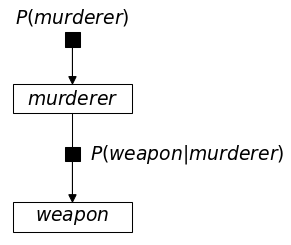

In [26]:
pgm = daft.PGM(node_ec='k',)
pgm.add_node("murderer_param", r"$P(murderer)$", 0.5, 2, offset=(0.1, 10), scale=3, fixed=True, shape="rectangle", label_params={"color": "k"})
pgm.add_node("murderer", r"$murderer$", 0.5, 1, aspect=4, shape="rectangle", label_params={"color": "k"})
pgm.add_node("cpt", r"$P(weapon|murderer)$", 0.5, 0.0625, offset=(110, -10), scale=3, fixed=True, shape="rectangle", label_params={"color": "k"})
pgm.add_node("weapon", r"$weapon$", 0.5, -1, aspect=4, shape="rectangle", label_params={"color": "k"})

pgm.add_edge("murderer_param", "murderer", plot_params={"head_width": 0.25,})
pgm.add_edge("murderer", "cpt", directed=False)
pgm.add_edge("cpt", "weapon", plot_params={"head_width": 0.25,})
pgm.render();

#### **Figure 1.10**

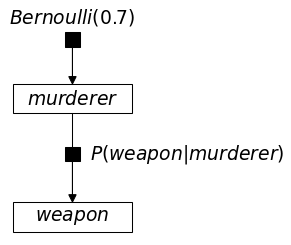

In [27]:
pgm = daft.PGM(node_ec='k',)
pgm.add_node("murderer_param", r"$Bernoulli(0.7)$", 0.5, 2, offset=(0.1, 10), scale=3, fixed=True, shape="rectangle", label_params={"color": "k"})
pgm.add_node("murderer", r"$murderer$", 0.5, 1, aspect=4, shape="rectangle", label_params={"color": "k"})
pgm.add_node("cpt", r"$P(weapon|murderer)$", 0.5, 0.0625, offset=(110, -10), scale=3, fixed=True, shape="rectangle", label_params={"color": "k"})
pgm.add_node("weapon", r"$weapon$", 0.5, -1, aspect=4, shape="rectangle", label_params={"color": "k"})

pgm.add_edge("murderer_param", "murderer", plot_params={"head_width": 0.25,})
pgm.add_edge("murderer", "cpt", directed=False)
pgm.add_edge("cpt", "weapon", plot_params={"head_width": 0.25,})
pgm.render();

#### **Figure 1.11**

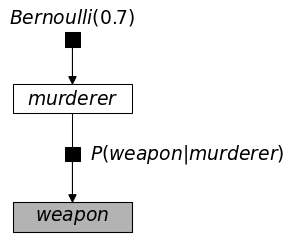

In [28]:
pgm = daft.PGM(node_ec='k',)
pgm.add_node("murderer_param", r"$Bernoulli(0.7)$", 0.5, 2, offset=(0.1, 10), scale=3, fixed=True, shape="rectangle", label_params={"color": "k"})
pgm.add_node("murderer", r"$murderer$", 0.5, 1, aspect=4, shape="rectangle", label_params={"color": "k"})
pgm.add_node("cpt", r"$P(weapon|murderer)$", 0.5, 0.0625, offset=(110, -10), scale=3, fixed=True, shape="rectangle", label_params={"color": "k"})
pgm.add_node("weapon", r"$weapon$", 0.5, -1, aspect=4, shape="rectangle", observed=True, label_params={"color": "k"})

pgm.add_edge("murderer_param", "murderer", plot_params={"head_width": 0.25,})
pgm.add_edge("murderer", "cpt", directed=False)
pgm.add_edge("cpt", "weapon", plot_params={"head_width": 0.25,})
pgm.render();

#### **1.22**
$P\, (\texttt{weapon}, \texttt{murderer}) = P\, (\texttt{weapon}|\texttt{murderer})P\, (\texttt{murderer})$

#### **1.23**
$P\, (\texttt{weapon}, \texttt{murderer}) = P\, (\texttt{murderer}|\texttt{weapon})P\, (\texttt{weapon})$

#### **1.24**
$P\, (\texttt{murderer}|\texttt{weapon}) = \frac{P\, (\texttt{weapon}|\texttt{murderer})P\, (\texttt{murderer})}{P\, (\texttt{weapon})}$

#### **1.25**
$P\, (\texttt{weapon}) = \sum_{murderer} P\, (\texttt{weapon}|\texttt{murderer})P\, (\texttt{murderer}) $

#### **1.26**
$P\, (\texttt{murderer}|\texttt{weapon}) \propto P\, (\texttt{weapon}|\texttt{murderer})P\, (\texttt{murderer})$

#### **1.27**
$P\, (\texttt{A}|\texttt{B}) = \frac{P\, (\texttt{A})P\, (\texttt{B}|\texttt{A})}{P\, (\texttt{B})}$

#### **1.28**
$\textrm{posterior} = \frac{\textrm{prior}\, \times \,\textrm{likelihood}}{\textrm{normalizer}}$

#### **1.29**
$P\, (\texttt{B}) = \sum_A P\, (\texttt{A})P\, (\texttt{B}|\texttt{A}) $ 

**Prior** - Initial suspicion is toward Miss Auburn with a probability of 70%, giving:

$$P(murderer = Auburn) \backsim Bernoulli(0.7)$$

* Therefore when murderer = 1 the murderer = Auburn

In [29]:
guess = 0.7

**Weapon** - There are two possible murder weapons, a revolver and a dagger. Suppose Major Grey were the murderer. We might believe that the probability of his choosing a revolver rather than a dagger for the murder is, say, 90% on the basis that he is ex-military and would be familiar with the use of guns. But if instead Miss Auburn were the murderer, we might think the probability of her using a revolver would be much smaller, say 20%, on the basis that she is unlikely to be familiar with the operation of an old revolver and is therefore more likely to choose the dagger.

$P(weapon | murderer) =\begin{bmatrix}
P(revolver | Grey) & P(dagger | Grey) \\
P(revolver | Auburn) & P(dagger | Auburn)
\end{bmatrix}$

$P(weapon | murderer) =\begin{bmatrix}
0.9 & 0.1 \\
0.2 & 0.8 
\end{bmatrix}$

- we have the rows reperesenting which murderer, and the columns repersenting each weapon resulting in the following codes for the weapons:

$ weapon = 0 => weapon = revolver$

$ weapon = 1 => weapon = dagger$

In [30]:
weapon_cpt = jnp.array([[0.9, 0.1], [0.2, 0.8]])

In [31]:
def mystery(guess):
    weapon_cpt = jnp.array([[0.9, 0.1], [0.2, 0.8]])
    murderer = numpyro.sample("murderer", dist.Bernoulli(guess))
    weapon = numpyro.sample("weapon", dist.Categorical(weapon_cpt[murderer]))
    return murderer, weapon

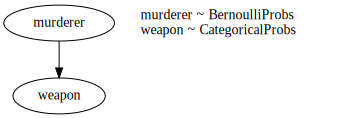

In [32]:
numpyro.render_model(mystery, (guess,), render_distributions=True)

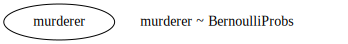

In [33]:
def model():
    sample = numpyro.sample("murderer", dist.Bernoulli(0.5))
    
numpyro.render_model(model, {}, render_distributions=True)

**A Clue** - *Searching carefully around the library, Dr Bayes spots a bullet lodged in the book case. “Hmm, interesting”, he says, “I think this could be an important clue”.* So it seems that the murder weapon was the revolver, not the dagger. Our intuition is that this new evidence points more strongly towards Major Grey than it does to Miss Auburn, since the Major, with his military background, is more likely to have experience with a revolver than Miss Auburn. But how can we use this information?

In [34]:
conditioned_model = numpyro.handlers.condition(mystery, {"weapon": 0.0})

In [35]:
num_warmup = 1000
num_samples = 1000
num_chains = 4

In [36]:
predictive = Predictive(conditioned_model, num_samples=num_chains*num_samples, infer_discrete=True,)
discrete_samples = predictive(rng_key, guess)

In [37]:
for key in discrete_samples.keys():
    discrete_samples[key] = np.array(discrete_samples[key].reshape(num_chains,num_samples))

In [38]:
az.stats.summary(discrete_samples["murderer"], hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.33,0.47,0.0,1.0,0.007,0.005,4149.0,4000.0,1.0


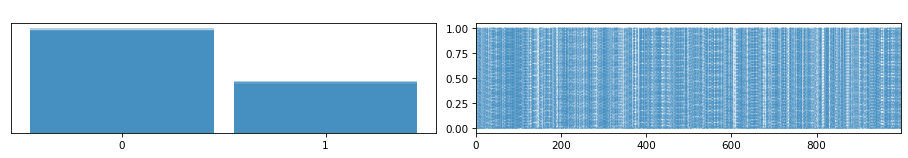

In [39]:
az.plot_trace(discrete_samples["murderer"]);

In [40]:
grey_revolver = 1 - discrete_samples["murderer"].mean()
auburn_revolver = discrete_samples["murderer"].mean()
print(f"P(murderer=Grey|weapon=revolver) = {grey_revolver:.2f}")
print(f"P(murderer=Auburn|weapon=revolver) = {auburn_revolver:.2f}")

P(murderer=Grey|weapon=revolver) = 0.67
P(murderer=Auburn|weapon=revolver) = 0.33


In [41]:
tol = 1e-2
np.testing.assert_allclose(
    (0.3 * 0.9) / ((0.3 * 0.9) + (0.7 * 0.2)),
    grey_revolver,
    rtol=tol,
    atol=tol,
)
np.testing.assert_allclose(
    (0.7 * 0.2) / ((0.3 * 0.9) + (0.7 * 0.2)),
    auburn_revolver,
    rtol=tol,
    atol=tol,
)

## 1.4 Working with larger models

In [42]:
hair_cpt = np.array([[0.5, 0.5], [0.95, 0.05]])

**Another Clue** - *Dr Bayes pulls out his trusty magnifying glass and continues his investigation of the crime scene. As he examines the floor near Mr Black’s body he discovers a hair lying on top of the pool of blood. “Aha” exclaims Dr Bayes “this hair must belong to someone who was in the room when the murder took place!” Looking more closely at the hair, Dr Bayes sees that it is not the lustrous red of Miss Auburn’s vibrant locks, nor indeed the jet black of the victim’s hair, but the distinguished silver of Major Grey!* 

#### **1.32**

In [43]:
lt(r"$P\,(\,\texttt{hair}=\texttt{true}\,|\, \texttt{murderer} \,) = \bigg\{\begin{array}{ll} %s \:\text{if}\: \texttt{murderer} = \texttt{Grey}\\%s \:\text{if}\: \texttt{murderer} = \texttt{Auburn} \end{array}$" % (hair_cpt[0][0], hair_cpt[1][1]))

<IPython.core.display.Latex object>

The hair is powerful evidence indicating that Major Grey was present at the time of the murder, but there is also the possibility that the hair was stolen by Miss Auburn and planted at the crime scene to mislead our perceptive sleuth. As before, we can capture these thoughts quantitatively using a conditional probability distribution. Let us denote the new information by the random variable hair, which takes the value true if Major Grey’s hair is discovered at the scene of the crime, and false otherwise. Clearly the discovery of the hair points much more strongly to Grey than to Auburn, but it does not rule out Auburn completely.

Suppose we think there is a 50% chance that Grey would accidentally leave one of his hairs at the crime scene if he were the murderer, but that there is only a 5% chance that Auburn would think to plant a grey hair if she were the murderer.

$P(hair | murderer) =\begin{bmatrix}
P(False | Grey) & P(True | Grey) \\
P(False | Auburn) & P(True | Auburn)
\end{bmatrix}$

$P(hair | murderer) =\begin{bmatrix}
0.5 & 0.5 \\
0.95 & 0.05 
\end{bmatrix}$

- we have the rows reperesenting which murderer, and the columns repersenting each weapon resulting in the following codes for the weapons:

$ hair = 0 => hair = False$

$ hair = 1 => hair = True$

#### **1.33**
$P\, (\texttt{hair}|\texttt{weapon,murderer}) = P\, (\texttt{hair}|\texttt{murderer}) $

#### **Figure 1.12**

/home/benda/anaconda3/envs/mbml_numpyro/lib/python3.9/site-packages/daft.py:842: RuntimeWarning: divide by zero encountered in double_scalars
  * np.abs(dy / dx)


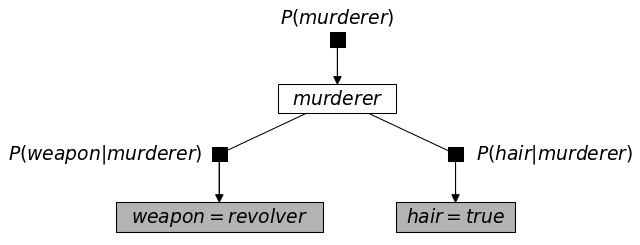

In [44]:
pgm = daft.PGM(node_ec='k',)
pgm.add_node("murderer_param", r"$P(murderer)$", 0.5, 2, offset=(0.1, 10), scale=3, fixed=True, shape="rectangle", label_params={"color": "k"})
pgm.add_node("murderer", r"$murderer$", 0.5, 1, aspect=4, shape="rectangle", label_params={"color": "k"})
pgm.add_node("weapon_cpt", r"$P(weapon|murderer)$", -1.5, 0.0625, offset=(-110, -10), scale=3, fixed=True, shape="rectangle", label_params={"color": "k"})
pgm.add_node("weapon", r"$weapon=revolver$", -1.5, -1, aspect=7, shape="rectangle", observed=True, label_params={"color": "k"})
pgm.add_node("hair_cpt", r"$P(hair|murderer)$", 2.5, 0.0625, offset=(95, -10), scale=3, fixed=True, shape="rectangle", label_params={"color": "k"})
pgm.add_node("hair", r"$hair = true$", 2.5, -1, aspect=4, shape="rectangle", observed=True, label_params={"color": "k"})

pgm.add_edge("murderer_param", "murderer", plot_params={"head_width": 0.25,})
pgm.add_edge("murderer", "weapon_cpt", directed=False)
pgm.add_edge("weapon_cpt", "weapon", plot_params={"head_width": 0.25,})
pgm.add_edge("murderer", "hair_cpt", directed=False)
pgm.add_edge("hair_cpt", "hair", plot_params={"head_width": 0.25,})
pgm.render();

#### **1.34**
$P\, (\texttt{murderer,weapon,hair}) = P\, (\texttt{murderer})P\, (\texttt{weapon}|\texttt{murderer})P\, (\texttt{hair}|\texttt{murderer})$

#### **1.35**
$P\, (\texttt{murderer}|\texttt{hair,weapon}) = \frac{P\, (\texttt{weapon}|\texttt{murderer})P\, (\texttt{hair}|\texttt{murderer,weapon})}{P\, (\texttt{hair}|\texttt{weapon})}$

#### **1.36**
$P\, (\texttt{murderer}|\texttt{weapon,hair}) \propto P\, (\texttt{murderer}|\texttt{weapon})P\, (\texttt{hair}|\texttt{murderer,weapon})$

#### **1.37**
$P\, (\texttt{murderer}|\texttt{weapon,hair}) \propto P\, (\texttt{murderer}|\texttt{weapon})P\, (\texttt{hair}|\texttt{murderer})$

#### **1.38**
$P\, (\texttt{murderer}|\texttt{weapon}=\texttt{revolver,hair}=\texttt{true}) \propto P\, (\texttt{murderer}|\texttt{weapon}=\texttt{revolver})P\, (\texttt{hair}=\texttt{true}|\texttt{murderer})$

In [45]:
def mystery_extend(guess):
    weapon_cpt = jnp.array([[0.9, 0.1], [0.2, 0.8]])
    hair_cpt = jnp.array([[0.5, 0.5], [0.95, 0.05]])
    murderer = numpyro.sample("murderer", dist.Bernoulli(guess))
    weapon = numpyro.sample("weapon", dist.Categorical(weapon_cpt[murderer]))
    hair = numpyro.sample("hair", dist.Categorical(hair_cpt[murderer]))
    return murderer, weapon, hair

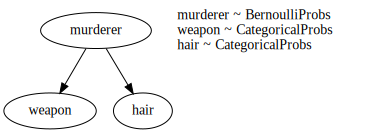

In [46]:
numpyro.render_model(mystery_extend, (guess,), render_distributions=True)

In [47]:
conditioned_model_extend = numpyro.handlers.condition(mystery_extend, {"weapon": 0.0, "hair": 1.0})

In [48]:
rng_key, rng_key_ = jax.random.split(rng_key)

In [49]:
predictive = Predictive(conditioned_model_extend, num_samples=num_chains*num_samples, infer_discrete=True,)
discrete_samples = predictive(rng_key_, guess)

In [50]:
for key in discrete_samples.keys():
    discrete_samples[key] = np.array(discrete_samples[key].reshape(num_chains,num_samples))

In [51]:
az.stats.summary(discrete_samples["murderer"], hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.052,0.222,0.0,0.0,0.004,0.002,4023.0,4000.0,1.0


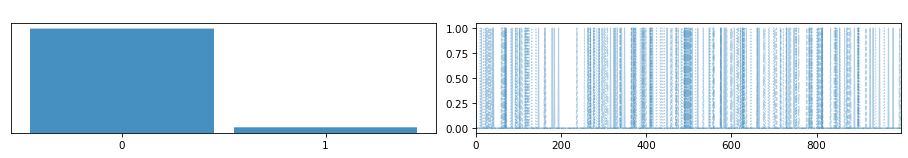

In [52]:
az.plot_trace(discrete_samples["murderer"]);

In [53]:
grey_revolver_hair = 1 - discrete_samples["murderer"].mean()
auburn_revolver_hair = discrete_samples["murderer"].mean()
print(f"P(murderer=Grey|weapon=rev.,hair=true) = {grey_revolver_hair:.2f}")
print(f"P(murderer=Auburn|weapon=rev.,hair=true) = {auburn_revolver_hair:.2f}")

P(murderer=Grey|weapon=rev.,hair=true) = 0.95
P(murderer=Auburn|weapon=rev.,hair=true) = 0.05


In [54]:
tol = 1e-2
np.testing.assert_allclose(
    (0.66 * 0.5) / ((0.66 * 0.5) + (0.34 * 0.05)),
    grey_revolver_hair,
    rtol=tol,
    atol=tol,
)
np.testing.assert_allclose(
    (0.34 * 0.05) / ((0.66 * 0.5) + (0.34 * 0.05)),
    auburn_revolver_hair,
    rtol=tol,
    atol=tol,
)

**Recap** - We can plot how the probability distribution over murderer changed over the course of our murder investigation (Figure 1.13, below). Notice how the probability of Grey being the murderer started out low and increased as each new piece of evidence stacked against him. Similarly, notice how the probability of Auburn being the murderer evolved in exactly the opposite direction, due to the normalization constraint and the assumption that either one of the two suspects was the murderer. We could seek further evidence, in the hope that this would change the probability distribution to be even more confident (although, of course, evidence implicating Auburn would have the opposite effect). Instead, we will stop here – since 95% is greater than our threshold of 91% and so enough for a conviction! 

In [55]:
auburn_prior, auburn_after_weapon, auburn_after_hair = (
    guess,
    auburn_revolver,
    auburn_revolver_hair,
)

grey_prior, grey_after_weapon, grey_after_hair = (
    1 - guess,
    grey_revolver,
    grey_revolver_hair,
)

#### **Figure 1.13**

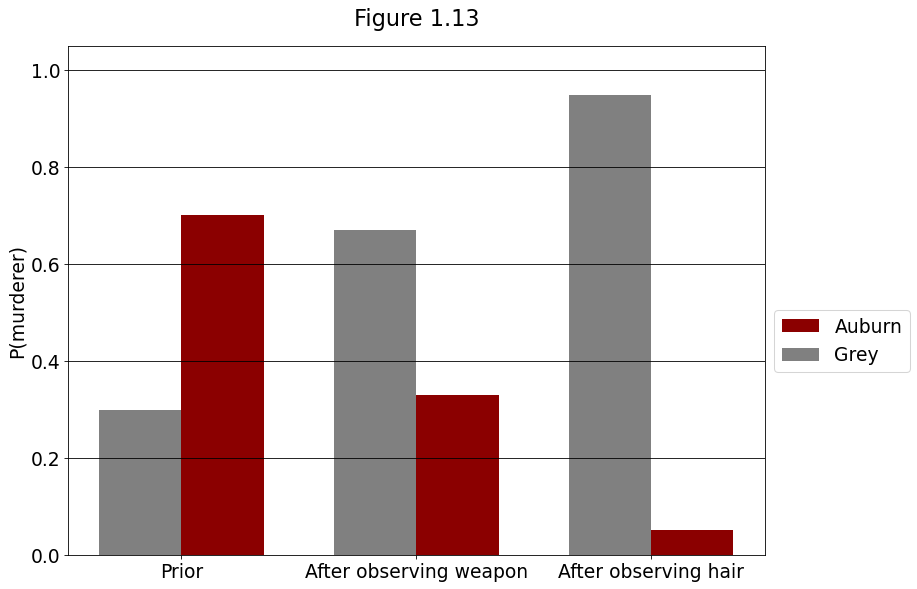

In [56]:
# adopted from https://github.com/MicPie/pyro/blob/master/MBML_Chapter1_MurderMystery.ipynb
auburn_ = (auburn_prior, auburn_after_weapon, auburn_after_hair)
grey_ = (grey_prior, grey_after_weapon, grey_after_hair)
ind = np.arange(len(auburn_))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 9))
rects1 = ax.bar(ind + width / 2, auburn_, width, color="darkred", label="Auburn")
rects2 = ax.bar(ind - width / 2, grey_, width, color="gray", label="Grey")

ax.set_title("Figure 1.13", color="black", pad=20)
ax.set_ylabel("P(murderer)")
ax.set_ylim((0, 1.05))
ax.set_xticks(ind)
ax.set_xticklabels(
    ("Prior", "After observing weapon", "After observing hair")
)
ax.legend(labelcolor="k", bbox_to_anchor=(1,0.5), loc="upper left")
ax.yaxis.grid(True, color ="black")
plt.show()

## Bonous - using plate notation
* Insted of writting each new evidence as their own array, we can vectorize over each table using `numpyro.plate`

In [57]:
from numpyro.contrib.indexing import Vindex

In [58]:
def mystery_plate(guess):
    murderer = numpyro.sample("murderer", dist.Bernoulli(guess))
    evidence = jnp.array([[[0.9, 0.1], [0.2, 0.8]], [[0.5, 0.5], [0.95, 0.05]], ])
    size = len(evidence)
    with numpyro.plate(f'i=1..{size}', size=size, dim=-1) as i:
        obs = numpyro.sample("evidence", dist.Categorical(Vindex(evidence)[murderer, i]))
    return murderer, obs

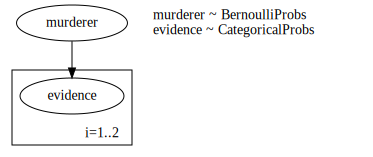

In [59]:
numpyro.render_model(mystery_plate, (guess,), render_distributions=True)

In [60]:
conditioned_model_plate = numpyro.handlers.condition(mystery_plate, {"evidence": jnp.array([0., 1.])})

In [61]:
do_model_plate = numpyro.handlers.do(mystery_plate, {"evidence": jnp.array([0., 1.])})

In [62]:
with numpyro.handlers.seed(rng_seed=0):
    for _ in range(5):
        print(do_model_plate(guess))

(DeviceArray(1, dtype=int32), DeviceArray([0., 1.], dtype=float32))
(DeviceArray(1, dtype=int32), DeviceArray([0., 1.], dtype=float32))
(DeviceArray(1, dtype=int32), DeviceArray([0., 1.], dtype=float32))
(DeviceArray(0, dtype=int32), DeviceArray([0., 1.], dtype=float32))
(DeviceArray(1, dtype=int32), DeviceArray([0., 1.], dtype=float32))


In [63]:
with numpyro.handlers.seed(rng_seed=0):
    samples = []
    for _ in range(5000):
        murderer, _ = do_model_plate(guess)
        samples.append((murderer.item(),))
pd.DataFrame(samples, columns=["murderer"])["murderer"].value_counts(normalize=True)

1    0.681
0    0.319
Name: murderer, dtype: float64

In [64]:
rng_key_, rng_key__ = jax.random.split(rng_key_)

In [65]:
predictive = Predictive(conditioned_model_plate, num_samples=num_chains*num_samples, infer_discrete=True,)
discrete_samples = predictive(rng_key__, guess)

In [66]:
discrete_samples["murderer"] = np.array(discrete_samples["murderer"].reshape(num_chains,num_samples))

In [67]:
az.stats.summary(discrete_samples["murderer"], hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.08,0.271,0.0,0.0,0.004,0.003,3744.0,3744.0,1.0


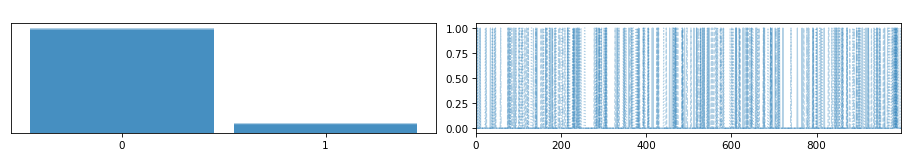

In [68]:
az.plot_trace(discrete_samples["murderer"]);